In [ ]:
from cdlib import algorithms
import networkx as nx
from cdlib import evaluation
import pandas as pd
import statistics
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate
from  cdlib.evaluation.fitness import FitnessResult
from collections import Counter

In [ ]:
#graph reading
G = nx.read_gexf('../network_analysis/data/rpolitics/giant_component.gexf')

# Comunity Discovery runs

In [ ]:
cd_algorithms = []

print('Leiden...')
leiden = algorithms.leiden(G) #louvain
cd_algorithms.append(leiden)
print('Leiden completed')

print('label_propagation...')
label_propagation = algorithms.label_propagation(G)
cd_algorithms.append(label_propagation)
print('label_propagation completed')

print('Scan...')
scan = algorithms.scan(G, epsilon=0.01, mu=3)
cd_algorithms.append(scan)
print('Scan completed')

G_infomap = nx.Graph()
for node in G.nodes():
  G_infomap.add_node(node)
for (u,v) in G.edges():
  G_infomap.add_edge(u,v, weight=G.edges[u,v]['weight'])

print('InfoMap')
infomap = algorithms.infomap(G_infomap)
cd_algorithms.append(infomap)
print('InfoMap completed')

print('Angel')
angel = algorithms.angel(G,min_community_size=3, threshold=0.7)
cd_algorithms.append(angel)
print('Angel completed')


Leiden...
Leiden completed
label_propagation...
label_propagation completed
Scan...
Scan completed
InfoMap
InfoMap completed
Angel
Angel completed


# Results analysis

## Internal score function

In [ ]:
def get_pol_mean(G,communities):
  communities_pol_score = []
  for community in communities:
    users_pol_score = []
    for node in community:
      node_data = G.nodes[node]
      if 'labels_political_leaning' in node_data:
        users_pol_score.append(node_data['labels_political_leaning'])
    communities_pol_score.append(sum(users_pol_score) / len(users_pol_score))
  return sum(communities_pol_score) / len(communities_pol_score)

In [ ]:
def find_majority(G, communities):
  left_communities = 0
  right_communities = 0

  for community in communities:
    counter = 0
    counter_right = 0 
    for n in community:
      user_data = G.nodes[n]
      if 'labels_political_leaning_cat' in user_data:
        counter += 1
        counter_right += user_data['labels_political_leaning_cat'] == 'r'
    
    if (counter_right / counter) > 0.5:
      right_communities += 1
    else:
      left_communities += 1

  return left_communities, right_communities

In [ ]:
def get_internal_metrics(G, algorithm):
  metrics = {}
  conductance = evaluation.conductance(G,algorithm, summary=True)
  edge_dens = evaluation.internal_edge_density(G,algorithm, summary=True)
  int_deg = evaluation.average_internal_degree(G,algorithm,summary=True)
  mod_dens = evaluation.newman_girvan_modularity(G,algorithm, summary=True)
  fomd = evaluation.fraction_over_median_degree(G,algorithm,summary=True)
  expansion = evaluation.expansion(G,algorithm,summary=True)
  triadic = evaluation.triangle_participation_ratio(G,algorithm,summary=True)
  pol_mean = get_pol_mean(G,algorithm.communities)
  left_communitites, right_communities = find_majority(G,algorithm.communities)

  metrics.update({
      "conductance": conductance,
      "edge_dens": edge_dens,
      "int_deg": int_deg,
      "mod_dens": mod_dens,
      "FOMD": fomd,
      "expansion": expansion,
      "triadic": triadic,
      "size": len(algorithm.communities),
      "max_size": max([len(com) for com in algorithm.communities]),
      "pol_mean": pol_mean,
      "left_communitites": left_communitites,
      "right_communities": right_communities
  })
  return metrics

In [ ]:
table = [['Alg ', 'conductance', 'edge_dens','int_deg','mod_dens', 'FOMD', "expansion", 'triadic','size', 'max_size','pol_mean','left_communitites','right_communitites']]

for alg in cd_algorithms:
  alg_metrics = [alg.method_name]
  alg_metrics.extend([el.score if isinstance(el,FitnessResult) else el for el in list(get_internal_metrics(G,alg).values())])
  table.append(alg_metrics)
print(tabulate(table))

-----------------  -------------------  -------------------  ------------------  ----------------------  -------------------  -------------------  --------------------  ----  --------  -------------------  -----------------  ------------------
Alg                conductance          edge_dens            int_deg             mod_dens                FOMD                 expansion            triadic               size  max_size  pol_mean             left_communitites  right_communitites
Leiden             0.3530722398471587   0.7829276158774545   1.305376888222635   0.2783061771811683      0.11246108207845117  1.0394081586857546   0.008445356354576446  314   15460     0.24458725145086185  289                25
Label Propagation  0.3607341833880391   0.8519166490591011   1.1703916239694971  0.01795489765700274     0.0901658676664692   0.6809742762795465   0.003198495649896671  2633  88482     0.24557894979408137  2431               202
SCAN               0.3269310364409268   0.6460367422737

## Additional analysis (Toxicity, Political Leaning)

In [ ]:
def get_additional_statistics(G=None, communities=None):
  results = []
  for community in communities:
    subG = G.subgraph(community)

    # Degree
    degrees = list(dict(subG.degree()).values())
    avg_degree = sum(degrees) / len(degrees)

    # Political leaning
    pol_lean = list(nx.get_node_attributes(subG,'labels_political_leaning').values())
    pol_lean_avg = sum(pol_lean) / len(pol_lean)

    clustering_mean = statistics.mean(nx.clustering(subG).values())

    pol_lean_cat = list(nx.get_node_attributes(subG,'labels_political_leaning_cat').values())

    left_wind = 0
    right_wind = 0
    for user_pol_cat in pol_lean_cat:
      if user_pol_cat == 'l':
        left_wind += 1
      else: 
        right_wind += 1

    # Toxicity
    hate = list(nx.get_node_attributes(subG,'labels_identity_hate').values())
    hate_avg = sum(hate) / len(hate)

    insult = list(nx.get_node_attributes(subG,'labels_insult').values())
    insult_avg = sum(insult) / len(insult)

    oscene = list(nx.get_node_attributes(subG,'labels_obscene').values())
    oscene_avg = sum(oscene) / len(oscene)

    sev_toxicity = list(nx.get_node_attributes(subG,'labels_severe_toxicity').values())
    sev_toxicity_avg = sum(sev_toxicity) / len(sev_toxicity)

    threat = list(nx.get_node_attributes(subG,'labels_threat').values())
    threat_avg = sum(threat) / len(threat)

    toxicity = list(nx.get_node_attributes(subG,'labels_toxicity').values())
    toxicity_avg = sum(toxicity) / len(toxicity)  
    
    # Geographical infromation
    geo = list(nx.get_node_attributes(subG,'geo').values())
    state_counter = {}

    state_counter = Counter(geo)

    community_result = {
        'n_nodes': len(community),
        'avg_degree': avg_degree,
        'pol_lean': pol_lean_avg,
        'left': left_wind,
        'right': right_wind,
        'clustering_avg': clustering_mean,
        'hate_avg': hate_avg,
        'insult_avg': insult_avg,
        'oscene_avg': oscene_avg,
        'sev_toxicity_avg': sev_toxicity_avg,
        'threat_avg': threat_avg,
        'toxicity_avg': toxicity_avg
    }
    community_result.update(state_counter)
    results.append(community_result)
  return pd.DataFrame(data = results)


In [ ]:
get_additional_statistics(G,label_propagation.communities[0:5])

,n_nodes,avg_degree,pol_lean,left,right,clustering_avg,hate_avg,insult_avg,oscene_avg,sev_toxicity_avg,threat_avg,toxicity_avg,New York,None,Texas,Arizona,Northern California,District of Columbia,Southern California,New Jersey,Virginia,South Carolina,Illinois,Massachusetts,Washington,Maryland,Missouri,Kansas,Ohio,Minnesota,Kentucky,Iowa,Colorado,Tennessee,Florida,Indiana,Nebraska,Oregon,Vermont,Pennsylvania,Maine,Nevada,Alaska,North Dakota,Connecticut,Michigan,Oklahoma,Wisconsin,Idaho,Rhode Island,North Carolina,Georgia,Hawaii,Louisiana,Mississippi,Central California,Alabama,New Hampshire,Montana,West Virginia,Arkansas,Utah,Wyoming,New Mexico
0,88482,10.218282,0.267595,71387,17093,0.036318,0.008349,0.050148,0.087124,0.008659,0.003915,0.141283,2021.0,61978,3132.0,676.0,1040.0,510.0,1860.0,755.0,677.0,177.0,1368.0,1301.0,2061.0,595.0,542.0,153.0,508.0,888.0,116.0,178.0,259.0,472.0,1399.0,359.0,64.0,543.0,183.0,1354.0,34.0,319.0,148.0,80.0,55.0,418.0,380.0,292.0,14.0,70.0,584.0,115.0,94.0,110.0,75.0,81.0,65.0,179.0,44.0,10.0,58.0,51.0,34.0,3.0
1,40,1.950000,0.294237,28,12,0.000000,0.015194,0.084221,0.069074,0.013495,0.026764,0.240771,NaN,34,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
2,34,1.941176,0.107941,31,3,0.000000,0.000458,0.000496,0.000377,0.000317,0.007430,0.011219,NaN,30,2.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,30,1.933333,0.293917,22,8,0.000000,0.007988,0.063361,0.096128,0.011886,0.010692,0.223751,NaN,22,NaN,NaN,NaN,NaN,2.0,NaN,1.0,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,30,1.933333,0.153622,26,4,0.000000,0.008210,0.072237,0.106216,0.012216,0.002096,0.152914,1.0,25,1.0,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Correlations

In [ ]:
mutual_matrix = []
names = []
vif_matrix = []
nf1_matrix = []
i = 0
for en_i, alg_i in enumerate(cd_algorithms):
  nf1_matrix.append([])
  if alg_i.method_name != 'SCAN' and alg_i.method_name != 'ANGEL':
    mutual_matrix.append([])
    vif_matrix.append([])
    names.append(alg_i.method_name)
  for alg_j in cd_algorithms:
    nf1_matrix[en_i].append(round(alg_i.f1(alg_j).score,5))
    if alg_j.method_name != 'SCAN' and alg_j.method_name != 'ANGEL' and alg_i.method_name != 'SCAN' and alg_i.method_name != 'ANGEL':
      mutual_matrix[i].append(round(alg_i.normalized_mutual_information(alg_j).score,5))
      vif_matrix[i].append(round(alg_i.variation_of_information(alg_j).score,5))
  if alg_i.method_name != 'SCAN' and alg_i.method_name != 'ANGEL':
    i += 1

In [ ]:
def plot_matrix_comparison(in_matrix, cd_algorithms, names, title):
  fig, ax = plt.subplots()
  ax.matshow(in_matrix, cmap=plt.cm.Pastel1)
  ax.set_xticklabels([''] + names, rotation=45)
  ax.set_yticklabels([''] + names)
  for i in range(len(in_matrix)):
      for j in range(len(in_matrix)):
          c = in_matrix[i][j]
          ax.text(i, j, str(c), va='center', ha='center')

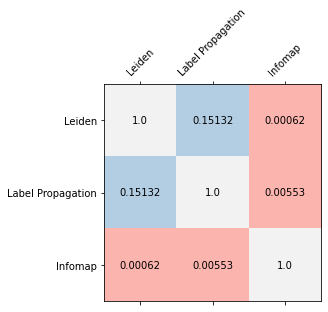

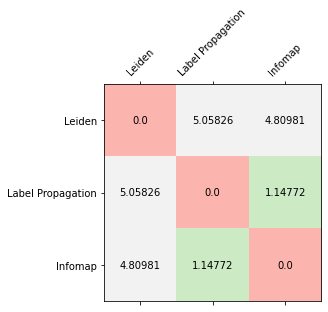

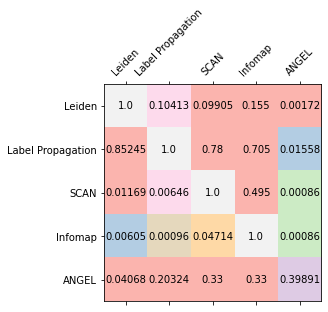

In [ ]:
plot_matrix_comparison(mutual_matrix, cd_algorithms, names, 'MI')
plot_matrix_comparison(vif_matrix, cd_algorithms, names, 'VI')
plot_matrix_comparison(nf1_matrix, cd_algorithms, [alg.method_name for alg in cd_algorithms], 'nf1')